# Hybrid A* 原理与代码

> Refs:
> - [Paper | Dmitri Dolgov, et. al. Practical Search Techniques in Path Planning for Autonomous Driving](https://www.aaai.org/Papers/Workshops/2008/WS-08-10/WS08-10-006.pdf)
> - [Python Code on github | PythonRobotics/Hybrid A*](https://github.com/Alexbeast-CN/PythonRobotics/tree/master/PathPlanning/HybridAStar)

## 1. 简介

Hybrid A* 是 2004 年 DARPA 城市挑战中的冠军车队使用的全局导航算法。相比与传统的 A* 算法，Hybrid A* 将由基于栅格地图的四邻域，八邻域的节点拓展方式，更换为了符合车辆动力学 (Kinodynamics) 的运动轨迹：

<center>

![拓展方式](./pics/expansion.png)

</center>

为什么我们需要 Kinodynamics 呢？因为车辆运动学模型的限制，车辆无法按照 A* 所生成的路径行走。例如如下图所示的情况，车辆最初的朝向是向下的，而 A* 的路径则是从障碍物的上方绕过去的。由于转弯半径的限制，这样的路径是无法跟随，而 Hybrid A* 则会考虑到车辆初始方向和终点方向，以及每一次节点拓展都符合车辆的运动学，因此生成的路径一定是车辆可以跟随的。

<center>

![A* 与 Hybrid A* 路径对比](./pics/Whykino.png)

</center>

## 2. 算法流程与实现


### 2.1 车辆的运动模型与碰撞模型

Ackman 底盘的汽车可以简化为一个两轮的自行车模型：

<center>

![自行车模型](./pics/kinematicsmodel.png)

</center>

该模型的运动学表达式为：

$$
\begin{align*}
  &\dot{x} = v \cos \psi \\
  &\dot{y} = v \sin \psi \\
  &\dot{\psi} = \frac{v}{l_f + l_r} \tan \delta
\end{align*}
$$

其中，$v$ 为车辆的线速度，$\psi$ 为车辆的朝向角，$\delta$ 为车辆的转向角，$l_f$ 为前轮距离车辆重心的距离，$l_r$ 为后轮距离车辆重心的距离。

其 Python 实现如下：

In [1]:
from math import cos, sin, tan, pi

def pi_2_pi(angle):
    return (angle + pi) % (2 * pi) - pi

def move(x, y, yaw, distance, steer, L):
    x += distance * cos(yaw)
    y += distance * sin(yaw)
    yaw += pi_2_pi(distance * tan(steer) / L)  # distance/2

    return x, y, yaw

假设现在有一辆车，其几何信息为：

- 宽度 W = 2m
- 前后轮的距离 WB = 3m
- 后轮到车最前端的距离为 LF = 3.3m
- 后轮到车最后端的距离为 LB = 1m
- 最大转向角为 $\pm$ pi/5
- 车辆的圆心与后轮相距 BUBBLE_DIST = (LF - LB) / 2
- 圆的半径为  BUBBLE_R = $\sqrt{}$ ((LF + LB) / 2)^2 + (W / 2)^2

```python

In [7]:
import numpy as np
import matplotlib.pyplot as plt

WB = 3.0  # rear to front wheel
W = 2.0  # width of car
LF = 3.3  # distance from rear to vehicle front end
LB = 1.0  # distance from rear to vehicle back end
MAX_STEER = pi/5  # [rad] maximum steering angle

BUBBLE_DIST = (LF - LB) / 2.0  # distance from rear to center of vehicle.
BUBBLE_R = np.hypot((LF + LB) / 2.0, W / 2.0)  # bubble radius

# vehicle rectangle vertices
VRX = [LF, LF, -LB, -LB, LF]
VRY = [W / 2, -W / 2, -W / 2, W / 2, W / 2]

由于车辆的运动轨迹只由质点表示，因此还需要对每一个路径点进行额外的碰撞检测。首先我们利用 [KDtree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) 获取车辆外接圆范围内的所有障碍物，然后对障碍物检查是否在车辆的矩形内。

In [13]:
def plot_arrow(x, y, yaw, length=1.0, width=0.5, fc="r", ec="k"):
    """Plot arrow."""
    if not isinstance(x, float):
        for (i_x, i_y, i_yaw) in zip(x, y, yaw):
            plot_arrow(i_x, i_y, i_yaw)
    else:
        plt.arrow(x, y, length * cos(yaw), length * sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width, alpha=0.4)

def rot_mat_2d(angle):
    return np.array([[cos(angle), -sin(angle)],
                     [sin(angle), cos(angle)]])
    
def plot_car(x, y, yaw):
    car_color = '-k'
    c, s = cos(yaw), sin(yaw)
    rot = rot_mat_2d(-yaw)
    car_outline_x, car_outline_y = [], []
    for rx, ry in zip(VRX, VRY):
        converted_xy = np.stack([rx, ry]).T @ rot
        car_outline_x.append(converted_xy[0]+x)
        car_outline_y.append(converted_xy[1]+y)
        
    arrow_x, arrow_y, arrow_yaw = c * 1.5 + x, s * 1.5 + y, yaw
    plot_arrow(arrow_x, arrow_y, arrow_yaw)
    plt.plot(car_outline_x, car_outline_y, car_color)
    
def plot_cllision_model(x, y, yaw):
    plot_car(x, y, yaw)
    plt.plot(x,y,marker='o',color='r')
    cx = x + BUBBLE_DIST * cos(yaw)
    cy = y + BUBBLE_DIST * sin(yaw)
    circle1 = plt.Circle((cx, cy), BUBBLE_R, color='r', fill=False)
    plt.gcf().gca().add_artist(circle1)



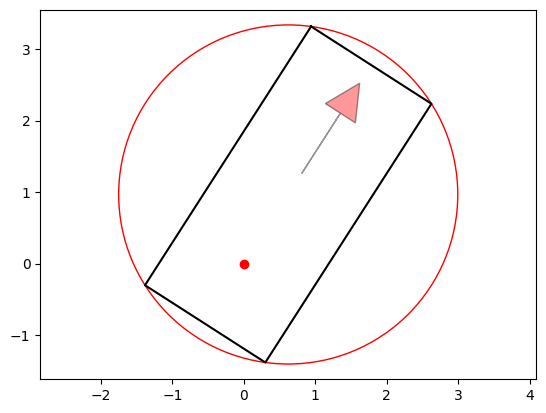

In [14]:
x, y, yaw = 0., 0., 1.
plt.axis('equal')
plot_cllision_model(x, y, yaw)
plt.show()

矩形碰撞检测，首先将障碍物的点利用旋转矩阵旋转到车辆坐标系下，然后判断障碍物的点是否在车辆的矩形内。算法代码如下：

In [15]:
def check_car_collision(x_list, y_list, yaw_list, ox, oy, kd_tree):
    for i_x, i_y, i_yaw in zip(x_list, y_list, yaw_list):
        cx = i_x + BUBBLE_DIST * cos(i_yaw)
        cy = i_y + BUBBLE_DIST * sin(i_yaw)

        ids = kd_tree.query_ball_point([cx, cy], BUBBLE_R)

        if not ids:
            continue

        if not rectangle_check(i_x, i_y, i_yaw,
                               [ox[i] for i in ids], [oy[i] for i in ids]):
            return False  # collision

    return True  # no collision


def rectangle_check(x, y, yaw, ox, oy):
    # transform obstacles to base link frame
    rot = rot_mat_2d(yaw)
    for iox, ioy in zip(ox, oy):
        tx = iox - x
        ty = ioy - y
        converted_xy = np.stack([tx, ty]).T @ rot
        rx, ry = converted_xy[0], converted_xy[1]

        if not (rx > LF or rx < -LB or ry > W / 2.0 or ry < -W / 2.0):
            return False  # no collision

    return True  # collision

### 2.2 地图、节点、与路径

对于任何机器人来说，地图都是有精度的，该精度与地图的尺度有关。通常机器人会储存两个以上的地图，一个尺度较大的地图，用于全局路径规划，但精度低。一个尺度较小的地图，用于局部路径规划，精度高。由于 Hybrid A* 是一个全局路径规划算法，所以这里所使用的地图精度为 2m。地图的角度精度为 5 度。地图上所有的点，以及角度都会被转换为整数。

In [ ]:
XY_GRID_RESOLUTION = 2.0  # [m]
YAW_GRID_RESOLUTION = np.deg2rad(5.0)  # [rad]

x_ind = round(x / XY_GRID_RESOLUTION)
y_ind = round(y / XY_GRID_RESOLUTION)
yaw_ind = round(yaw / YAW_GRID_RESOLUTION)

In [ ]:
class Node:

    def __init__(self, x_ind, y_ind, yaw_ind, direction,
                 x_list, y_list, yaw_list, directions,
                 steer=0.0, parent_index=None, cost=None):
        self.x_index = x_ind
        self.y_index = y_ind
        self.yaw_index = yaw_ind
        self.direction = direction
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        self.directions = directions
        self.steer = steer
        self.parent_index = parent_index
        self.cost = cost
        
class Path:

    def __init__(self, x_list, y_list, yaw_list, direction_list, cost):
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        self.direction_list = direction_list
        self.cost = cost

### 2.3 节点拓展

如第一节所述，使用车辆的运动学模型所拓展的点，其 (x, y) 并一定是个整数。但最终的路径还是依赖于栅格地图的，所以我们需要将拓展点的 (x, y) 坐标转换为栅格地图的坐标，即直接取整。

In [ ]:
XY_GRID_RESOLUTION = 2.0  # [m]
YAW_GRID_RESOLUTION = np.deg2rad(5.0)  # [rad]

x_ind = round(x / XY_GRID_RESOLUTION)
y_ind = round(y / XY_GRID_RESOLUTION)
yaw_ind = round(yaw / YAW_GRID_RESOLUTION)

### 2.4 One shot